In [33]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import onnxruntime as rt
import onnx
from skl2onnx.common.data_types import FloatTensorType
from skl2onnx import to_onnx
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from skl2onnx import convert_sklearn
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [4]:
df = pd.read_csv('investigation_train_large_checked.csv')
data_description = pd.read_csv('data_description.csv', encoding='latin1')
target = df['checked']
features = df.drop(columns=['Ja', 'Nee','checked'])
features.head()

,adres_aantal_brp_adres,adres_aantal_verschillende_wijken,adres_aantal_verzendadres,adres_aantal_woonadres_handmatig,adres_dagen_op_adres,adres_recentst_onderdeel_rdam,adres_recentste_buurt_groot_ijsselmonde,adres_recentste_buurt_nieuwe_westen,adres_recentste_buurt_other,adres_recentste_buurt_oude_noorden,...,typering_dagen_som,typering_hist_aantal,typering_hist_inburgeringsbehoeftig,typering_hist_ind,typering_hist_sector_zorg,typering_ind,typering_indicatie_geheime_gegevens,typering_other,typering_transport__logistiek___tuinbouw,typering_zorg__schoonmaak___welzijn
0,1,1,0,0,23240,1,0,0,0,0,...,-644,1,0,1,0,0,0,0,0,0
1,4,2,1,1,1971,1,0,0,1,0,...,3875,1,0,1,0,1,0,1,0,0
2,6,4,2,1,7247,0,0,0,1,0,...,3398,1,0,1,0,1,0,0,0,0
3,3,2,0,1,8060,1,0,0,1,0,...,128,1,0,1,0,0,0,0,0,0
4,3,2,0,0,18705,1,0,0,0,0,...,2210,1,0,1,0,1,0,0,0,0


In [5]:
checked_true = target.sum()
checked_false= len(target)-checked_true
print(len(target))
print('Checked == True: ',(checked_true/len(target))*100,'%')
print('Checked == False: ', (checked_false/len(target))*100,'%')
print(df.isnull().values.any())

130000
Checked == True:  15.003076923076922 %
Checked == False:  84.99692307692308 %
False


In [7]:
def get_protected_feature_indices():
    protected_indices = {
        'demographic': {
            'gender': [215],
            'age': [216],
            'language': [244,245,246,247]
        },
        'location': {
            'neighborhood': list(range(6,11)),
            'district': list(range(13,22)),
            'rotterdam': [11,12]
        },
        'family': {
            'children': list(range(282,289)),
            'partner': [302,303]
        },
        'health': {
            'physical': [54],
            'mental': [55],
            'medical': [67,68,69]
        },
        'financial': {
            'problems': [53,56],
            'income': [132,133,134]
        }
    }
    return protected_indices

def get_feature_importances():
    feature_importances = data_description['Relative importance']
    return feature_importances

def analyze_correlation_protected_features(data):
    protected_indices = get_protected_feature_indices()
    importances = get_feature_importances()
    results = {}

    for category, subcategories in protected_indices.items():
        results[category] = {}
        for subcategory, indices in subcategories.items():
            subcategory_results = []

            for idx in indices:
                protected_feature = data.columns[idx]

                for col_idx, col in enumerate(data.columns):
                    if col_idx == idx:
                        continue

                    correlation = data[protected_feature].corr(data[col], method='spearman')
                    importance = importances[col_idx]
                    risk_score = abs(correlation) * importance

                    if pd.notna(correlation):
                        subcategory_results.append({
                            'protected_feature': protected_feature,
                            'analyzed_feature': col,
                            'correlation': correlation,
                            'importance': importance,
                            'risk_score': risk_score
                        })

            subcategory_df = pd.DataFrame(subcategory_results)
            subcategory_df = subcategory_df.sort_values('risk_score',
                                                       ascending=False)

            results[category][subcategory] = subcategory_df

    return results

In [29]:
display_correlations = analyze_correlation_protected_features(features)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]


In [36]:
def display_correlation_results(results, top_n=5, correlation_threshold=0.5):
    for category, subcategories in results.items():
        print(f"\n{'='*80}")
        print(f"CATEGORY: {category.upper()}")
        print(f"{'='*80}")

        for subcategory, subcategory_df in subcategories.items():
            if isinstance(subcategory_df, pd.DataFrame) and not subcategory_df.empty:
                print(f"\nSUBCATEGORY: {subcategory}")
                print(f"{'-'*40}")

                # Display top N features by risk score
                print(f"\nTop {top_n} highest risk features:")
                top_features = subcategory_df.head(top_n)[
                    ['protected_feature', 'analyzed_feature', 'correlation',
                     'importance', 'risk_score']
                ]
                     # Create bar plot
                plt.figure(figsize=(10, 6))
                plt.gca().spines['top'].set_visible(False)
                bars = plt.bar(range(len(top_features)), top_features['risk_score'])

                # Customize the plot
                plt.title(f'Top {top_n} Risk Scores for {category} - {subcategory}')
                plt.xlabel('Features')
                plt.ylabel('Risk Score')

                # Rotate x-axis labels for better readability
                plt.xticks(range(len(top_features)),
                          top_features['analyzed_feature'],
                          rotation=45,
                          ha='right')

                # Add value labels on top of bars
                for bar in bars:
                    height = bar.get_height()
                    plt.text(bar.get_x() + bar.get_width()/2., height,
                            f'{height:.2f}',
                            ha='center', va='bottom')

                plt.tight_layout()
                plt.show()

                # Display features with strong correlations
                strong_correlations = subcategory_df[
                    abs(subcategory_df['correlation']) >= correlation_threshold
                ].sort_values('correlation', ascending=False)

                # Basic statistics
                print(f"\nSummary statistics:")
                print(f"- Total features analyzed: {len(subcategory_df)}")
                print(f"- Average absolute correlation: {subcategory_df['correlation'].abs().mean():.3f}")
                print(f"- Average risk score: {subcategory_df['risk_score'].mean():.3f}")
                print(f"- Number of strong correlations: {len(strong_correlations)}")
                print("\n")


CATEGORY: DEMOGRAPHIC

SUBCATEGORY: gender
----------------------------------------

Top 5 highest risk features:


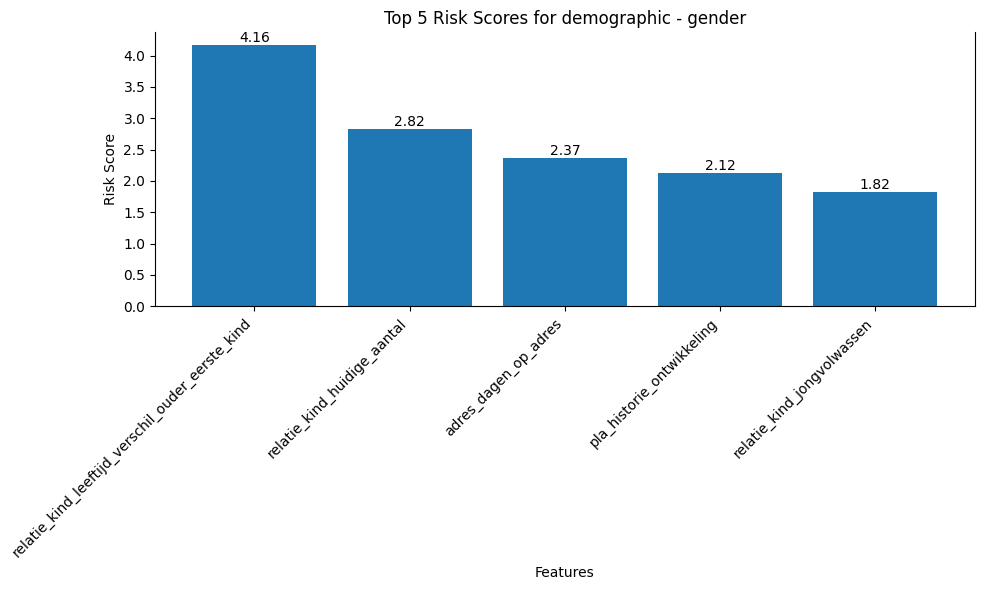


Summary statistics:
- Total features analyzed: 313
- Average absolute correlation: 0.037
- Average risk score: 0.135
- Number of strong correlations: 0



SUBCATEGORY: age
----------------------------------------

Top 5 highest risk features:


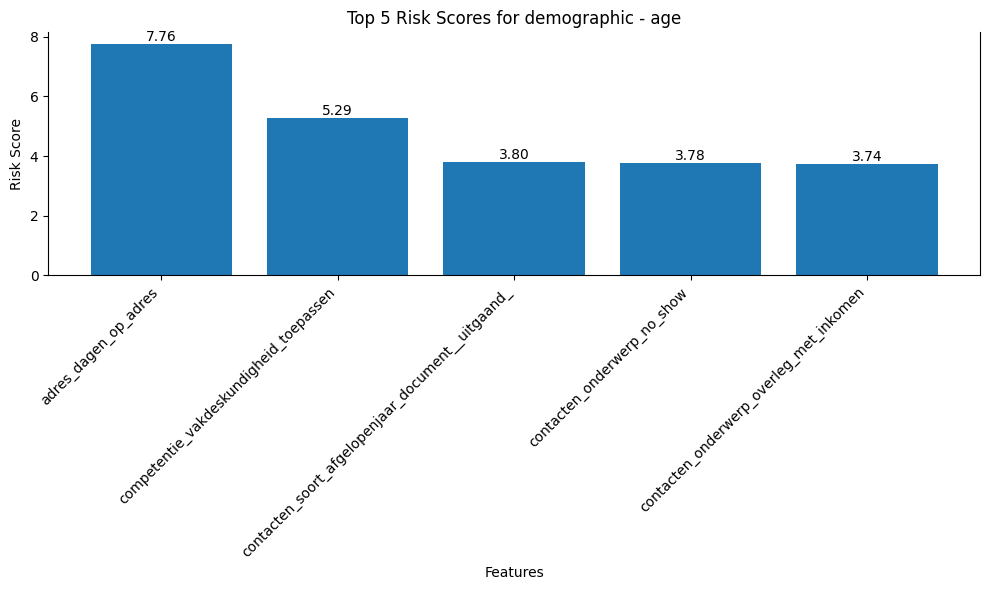


Summary statistics:
- Total features analyzed: 313
- Average absolute correlation: 0.082
- Average risk score: 0.228
- Number of strong correlations: 0



SUBCATEGORY: language
----------------------------------------

Top 5 highest risk features:


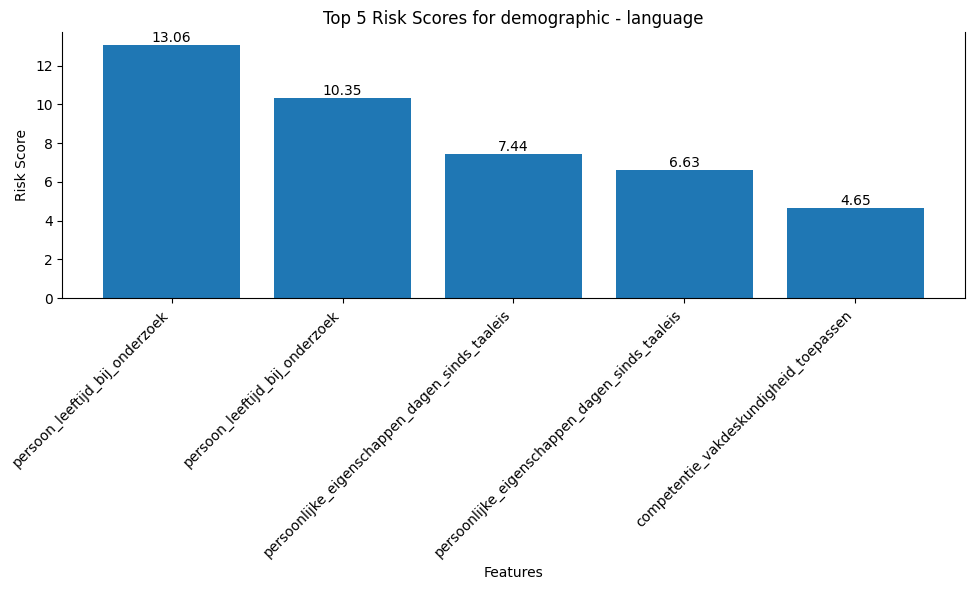


Summary statistics:
- Total features analyzed: 1252
- Average absolute correlation: 0.046
- Average risk score: 0.145
- Number of strong correlations: 0



CATEGORY: LOCATION

SUBCATEGORY: neighborhood
----------------------------------------

Top 5 highest risk features:


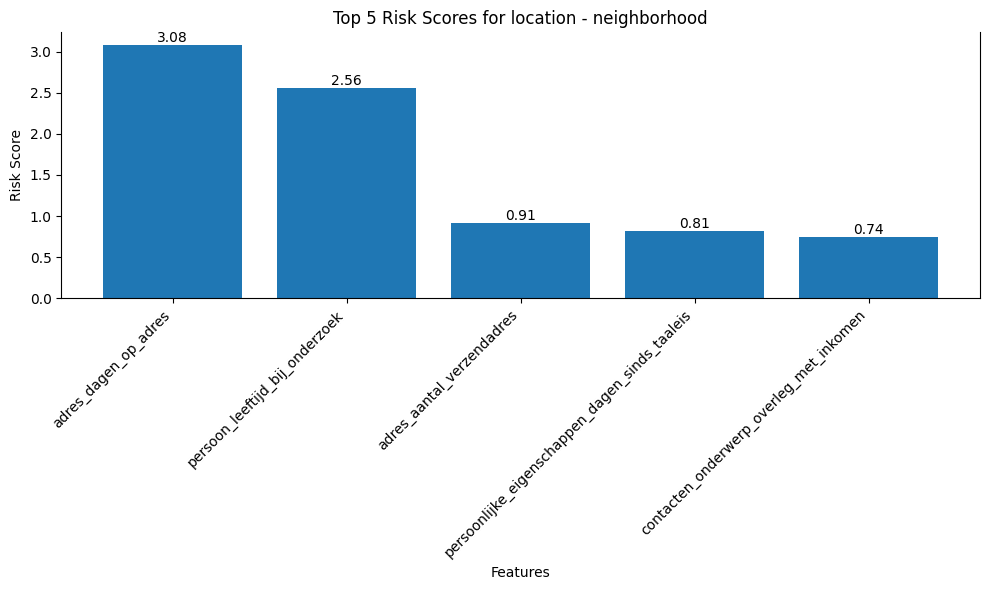


Summary statistics:
- Total features analyzed: 1565
- Average absolute correlation: 0.008
- Average risk score: 0.023
- Number of strong correlations: 0



SUBCATEGORY: district
----------------------------------------

Top 5 highest risk features:


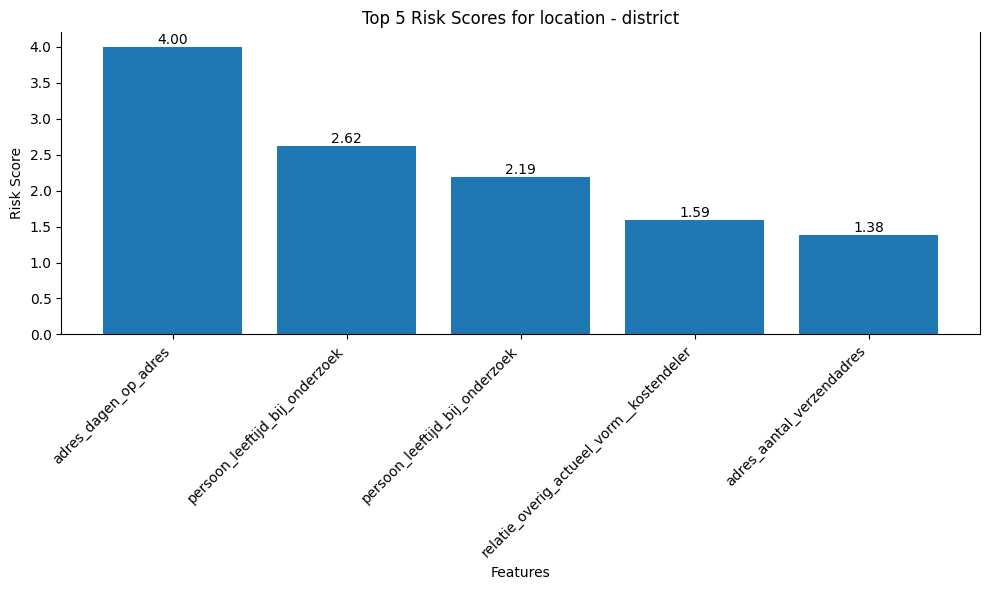


Summary statistics:
- Total features analyzed: 2817
- Average absolute correlation: 0.013
- Average risk score: 0.037
- Number of strong correlations: 1



SUBCATEGORY: rotterdam
----------------------------------------

Top 5 highest risk features:


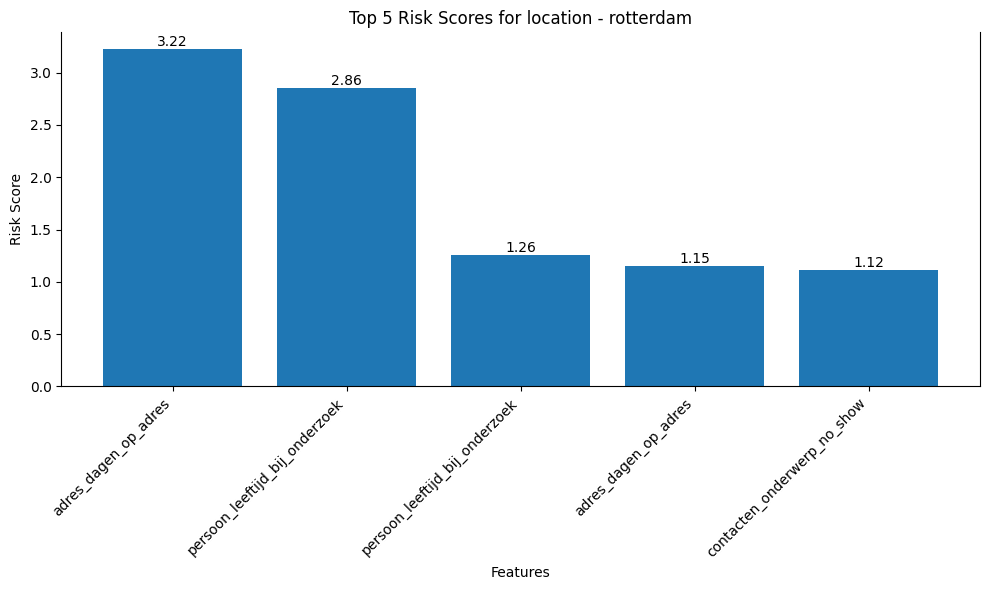


Summary statistics:
- Total features analyzed: 626
- Average absolute correlation: 0.016
- Average risk score: 0.049
- Number of strong correlations: 2



CATEGORY: FAMILY

SUBCATEGORY: children
----------------------------------------

Top 5 highest risk features:


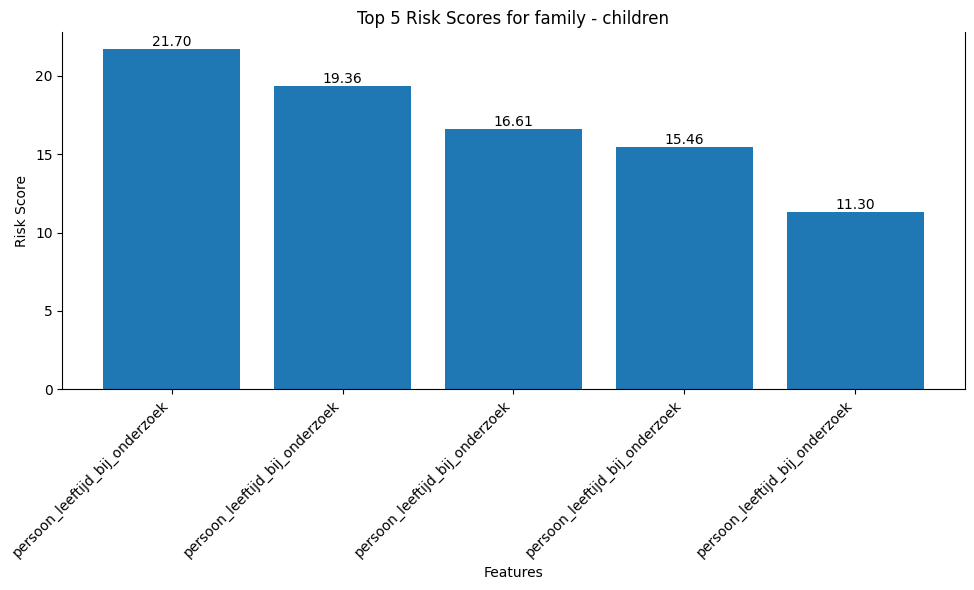


Summary statistics:
- Total features analyzed: 2191
- Average absolute correlation: 0.038
- Average risk score: 0.175
- Number of strong correlations: 8



SUBCATEGORY: partner
----------------------------------------

Top 5 highest risk features:


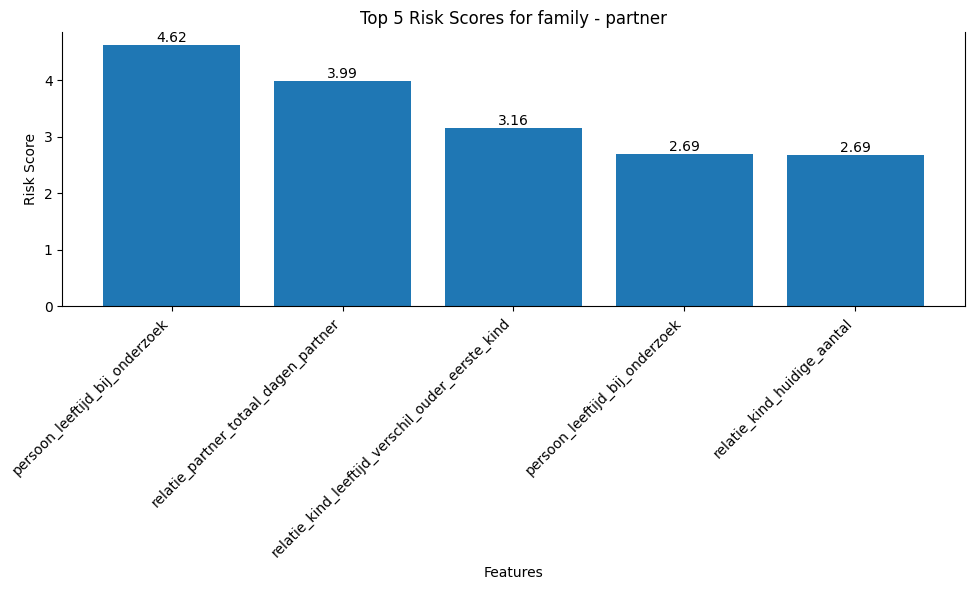


Summary statistics:
- Total features analyzed: 626
- Average absolute correlation: 0.020
- Average risk score: 0.074
- Number of strong correlations: 1



CATEGORY: HEALTH

SUBCATEGORY: physical
----------------------------------------

Top 5 highest risk features:


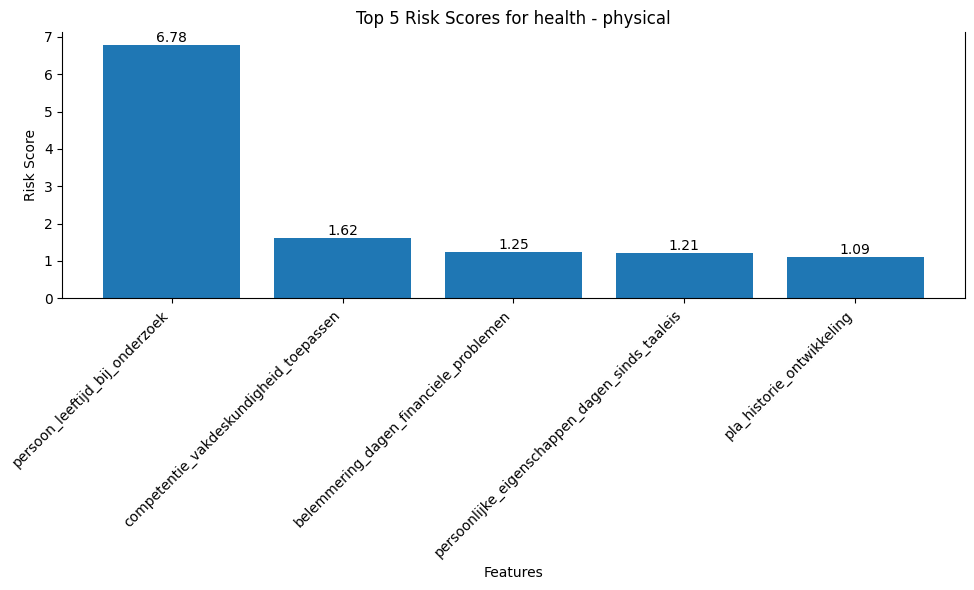


Summary statistics:
- Total features analyzed: 313
- Average absolute correlation: 0.036
- Average risk score: 0.102
- Number of strong correlations: 0



SUBCATEGORY: mental
----------------------------------------

Top 5 highest risk features:


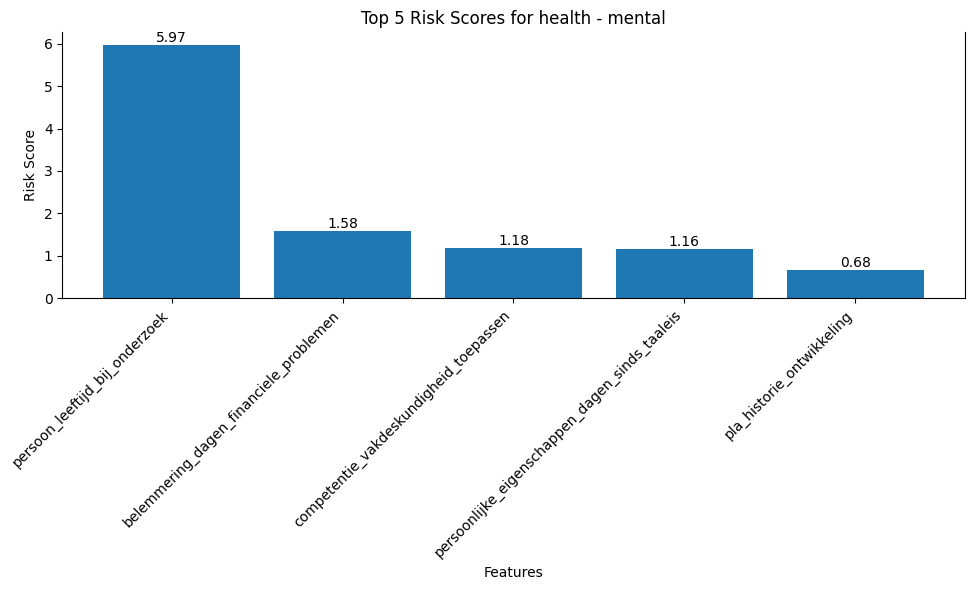


Summary statistics:
- Total features analyzed: 313
- Average absolute correlation: 0.027
- Average risk score: 0.076
- Number of strong correlations: 0



SUBCATEGORY: medical
----------------------------------------

Top 5 highest risk features:


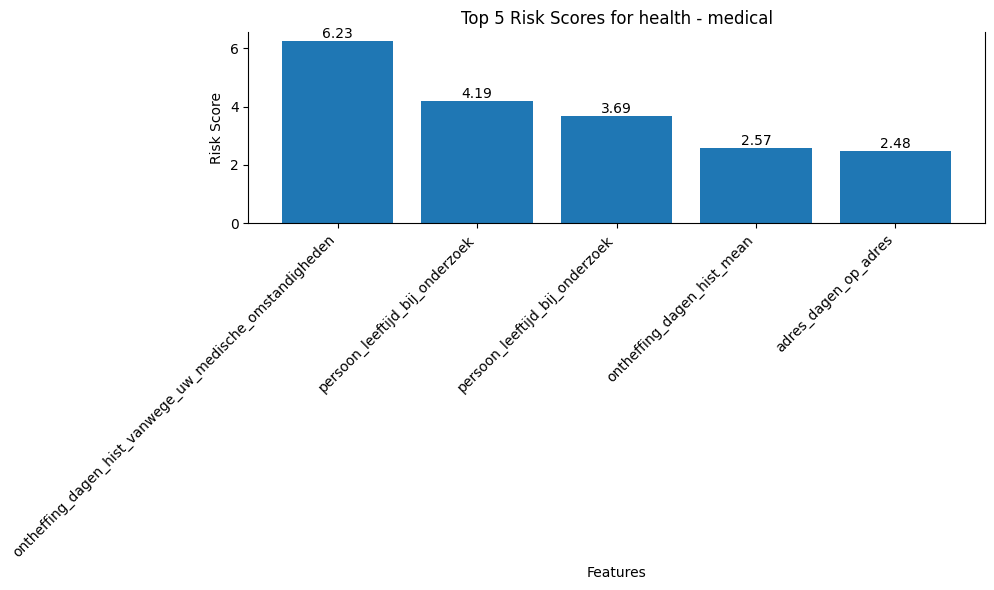


Summary statistics:
- Total features analyzed: 939
- Average absolute correlation: 0.025
- Average risk score: 0.074
- Number of strong correlations: 1



CATEGORY: FINANCIAL

SUBCATEGORY: problems
----------------------------------------

Top 5 highest risk features:


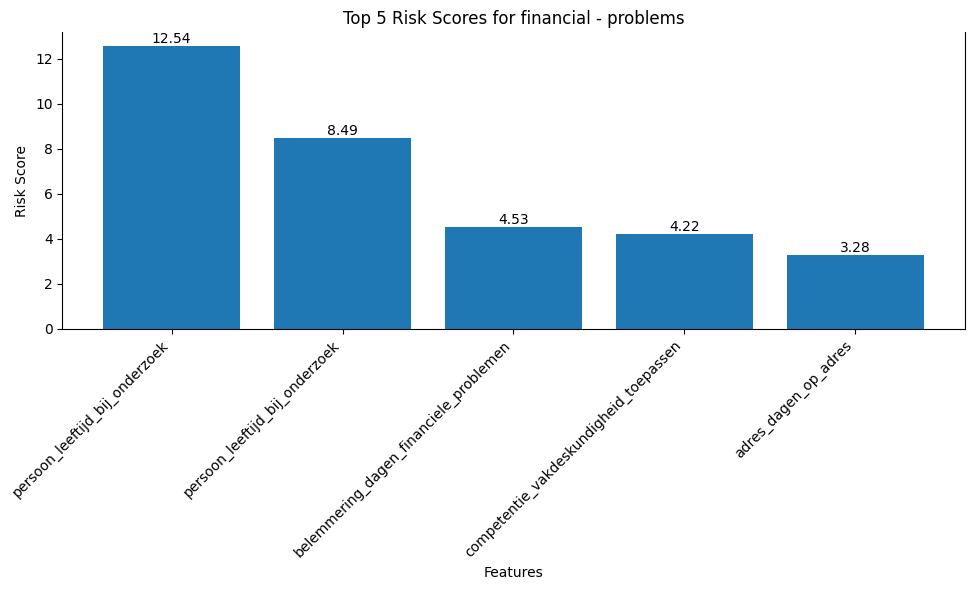


Summary statistics:
- Total features analyzed: 626
- Average absolute correlation: 0.059
- Average risk score: 0.178
- Number of strong correlations: 2



SUBCATEGORY: income
----------------------------------------

Top 5 highest risk features:


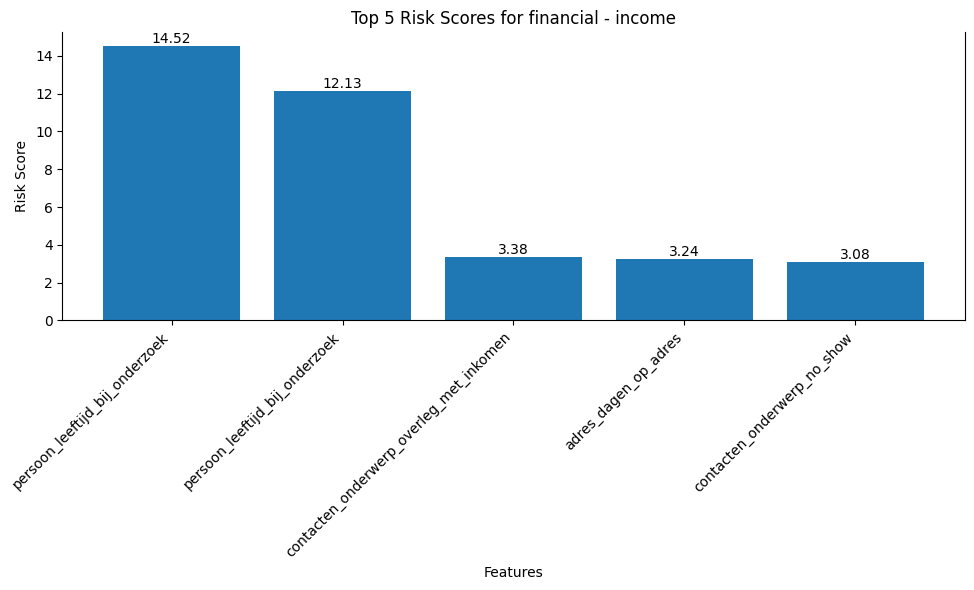


Summary statistics:
- Total features analyzed: 939
- Average absolute correlation: 0.047
- Average risk score: 0.147
- Number of strong correlations: 3




In [37]:
display_correlation_results(display_correlations)